<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelowanie krzywej OIS - przykład rynku GBP

# Wstęp

W tym notebooku prezentujemy model PCA-Factor Copula dla krzywej OIS rynku dłużnego funta.
Pokazujemy, że stopa OIS zależy od indexu SONIA, który natomiast jest zależny od stopy referencyjnej centralnego banku Wielkiej Brytanii.

Prezentujemy uproszczony model Hulla-White'a do symulacji indexu SONIA, co pozwala na ujęcie prognoz eksperckich co do zmian stopy referencyjnej. Pokazujemy również zastosowanie modelu PCA-Factor copula do modelowania ruchów krzywej OIS.

Cały model pozwala na symulację Monte Carlo ruchow krzywej OIS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
from typing import Callable, Optional
from datetime import date
from arch import arch_model
from sklearn.datasets import make_blobs
from statsmodels.distributions.empirical_distribution import ECDF


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyvinecopulib as pv

plt.style.use('seaborn-whitegrid')
sns.set_context('notebook')
sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['figure.figsize'] = (10, 8)

ImportError: ignored

# Dane

Dane dzienne dotyczące [OIS](https://www.bankofengland.co.uk/statistics/yield-curves) i [SONIA](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N) są publicznie dostępne na stronie Bank of England. 

Do dyspozycji mamy 6 lat dziennych obserwacji SONII oraz 60 tenorów krzywej OIS.


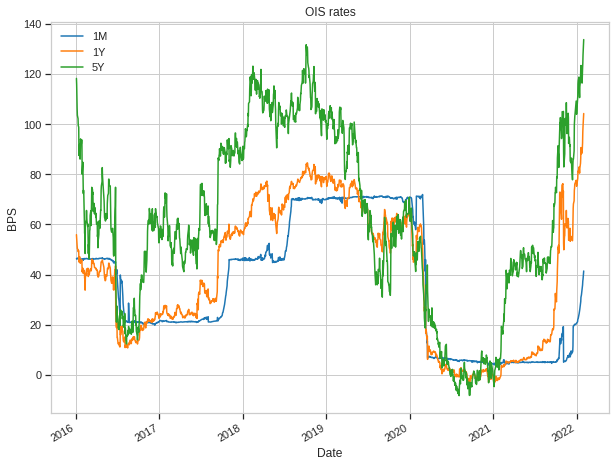

In [19]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/OIS%20spot.csv'
sonia_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/SONIA.csv'

def tenor_parser(month_number: int):
  """
  Refactor integer month number into string like: 23 -> '1Y3Q2M' 

  Parameters
  ----------
  month_number: int
    Integer representing the number of months
  
  Returns
  -------
  str
    Formatted string
  """
  years = np.floor(month_number/12)
  months = (month_number - 12*years)

  y_str = f"{int(years)}Y" * int(years > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + m_str

# OIS load
ois = pd.read_csv(ois_url,
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois.sort_index()*100.0
ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

# SONIA load
sonia = pd.read_csv(sonia_url,
                    index_col=['Date'], parse_dates=True, dayfirst=True)
sonia = sonia.sort_index()* 100.0

# Concatenate
rates = pd.concat([sonia, ois], axis = 1).dropna()

rates.iloc[:, [1, 12, 60]].plot()
plt.title('OIS rates')
plt.ylabel('BPS')
plt.xlabel('Date');

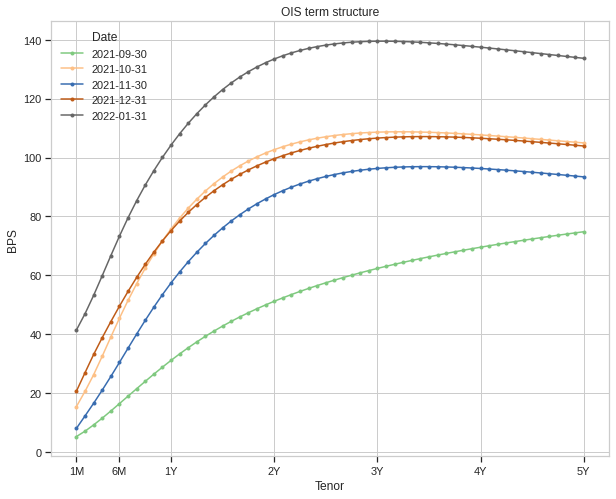

In [20]:
term_structure_df = rates.drop(['SONIA'], axis=1).tail(100).resample('M').last().T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.', cmap='Accent')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')
tenors = np.array([1, 6, 12, 24, 36, 48, 60]) - 1
plt.xticks(tenors, ois.columns[tenors]);

# Model indexu SONIA

Sterling Overnight Index Average (SONIA) to alternatywna stopa referencyjna dla rynku dłużnego funta, która ma zastąpić GBP LIBOR po całkowitym jego wygaśnięciu.

SONIA obliczana jest jako średnia ucinana zaokrąglana do 4 miejsc po przecinku, brana na podstawie stóp procentowych obowiązujących na spełniających opowiednie warunki transakcjach depozytowych denominowanych w funcie sterlingu. 
Średnia ucinana używana do obliczania SONII jest ważona wolumenem, i bazowana na środkowych 50% rozkładu stóp procentowych. Transakcje brane pod uwage muszą być:

- Niesekurytyzowane i o jednodniowym terminie wygaśnięcia
- Wykonane między 00:00 and 18:00 czasu UK, o zapadalności transakcji tego samego dnia
- O wartości większej lub równej 25 mln funtów

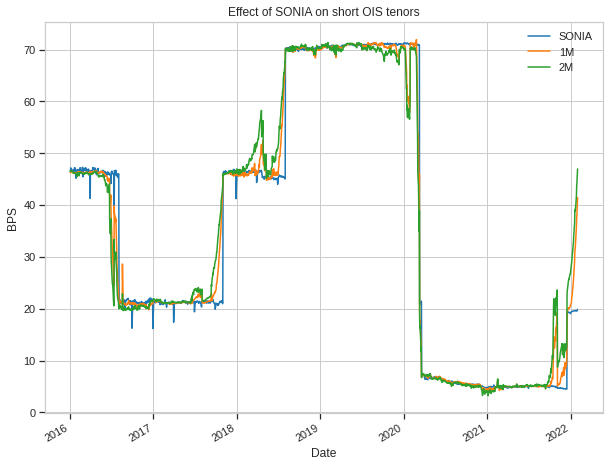

In [21]:
rates.iloc[:, :3].plot()
plt.title('Effect of SONIA on short OIS tenors')
plt.ylabel('BPS')
plt.xlabel('Date');

## Model Hulla-White'a

$$ dr_t = b(\mu_t - r_t)dt + \sigma dW_t$$ 


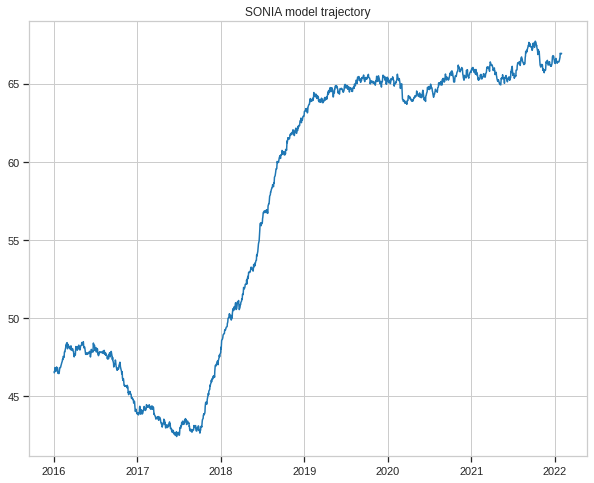

In [22]:
class HullWhiteModel():
    
  def __init__(self, b, mu_t, sigma):
    self.b = b
    self.mu_t = mu_t
    self.sigma = sigma

  def simulate(self,
               x0, dates):
    
    random_toss = np.random.rand(len(dates) - 1).round()*2 - 1
    dt = 1/255.

    for i, date in enumerate(dates):
      if i == 0:
        xt = [x0]
        t = [date]
      x_k = xt[-1] + self.b*(self.mu_t(t[-1]) - xt[-1])*dt + self.sigma*np.random.randn()*np.sqrt(dt)
      xt.append(x_k)
      t.append(date)
    return np.array(t), np.array(xt)

dates = np.array(ois.index)

def mu_t(date):
  if date < np.datetime64('2016-09-01'):
    return sonia.iloc[0]
  elif date < np.datetime64('2017-10-01'):
    return sonia.iloc[0] - 5.
  elif date < np.datetime64('2018-06-01'):
    return sonia.iloc[0] + 10.
  else:
    return sonia.iloc[0] + 20.

model = HullWhiteModel(b = 2.0, # 70.0
                       mu_t = mu_t,
                       sigma = 2.0) # 2.0

t, xt = model.simulate(dates = dates,
                       x0 = sonia.iloc[0])

plt.plot(t, xt)
plt.title('SONIA model trajectory');

## Jak polityka BoE wpływa na krzywą OIS?

- [BoE rate](https://www.bankofengland.co.uk/monetary-policy/the-interest-rate-bank-rate)
- [SONIA rate](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N)

## Model indexu SONIA, na podstawie BoE rate

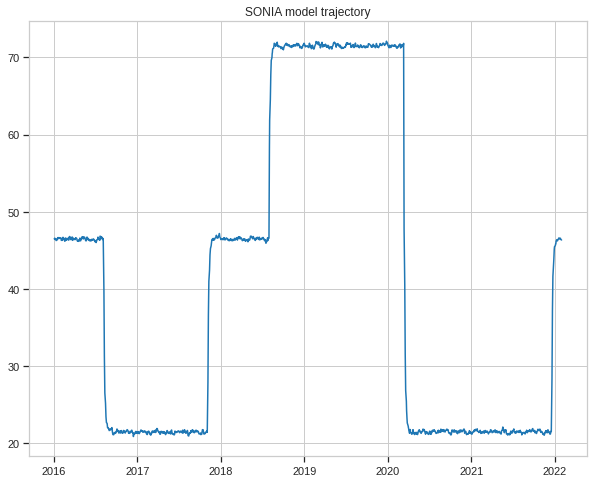

In [23]:
def boe_rate_pred(date):
  if date < np.datetime64('2016-08-05'):
    return sonia.iloc[0]
  elif date < np.datetime64('2017-11-03'):
    return sonia.iloc[0] - 25.
  elif date < np.datetime64('2018-07-31'):
    return sonia.iloc[0] + 0.
  elif date < np.datetime64('2020-03-11'):
    return sonia.iloc[0] + 25.
  elif date < np.datetime64('2020-03-20'):
    return sonia.iloc[0] - 25.
  elif date < np.datetime64('2020-03-20'):
    return sonia.iloc[0] - 40.
  elif date < np.datetime64('2021-12-17'):
    return sonia.iloc[0] - 25.
  else:
    return sonia.iloc[0] + 0.

model = HullWhiteModel(b = 70.0,
                       mu_t = boe_rate_pred,
                       sigma = 2.0)

t, xt = model.simulate(dates = dates,
                       x0 = sonia.iloc[0])

plt.plot(t, xt)
plt.title('SONIA model trajectory');

# Model dynamiki krzywej OIS



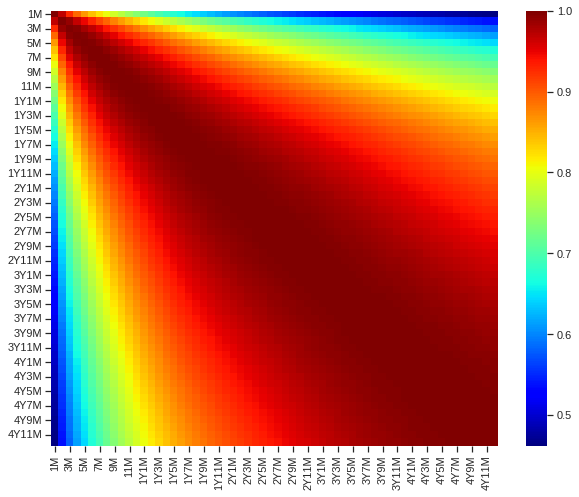

In [24]:
diffs = (rates[ois.columns].sub(rates['SONIA'], axis=0)).diff().dropna()

sns.heatmap(diffs.corr(), cmap='jet')

## PCA

### Idea


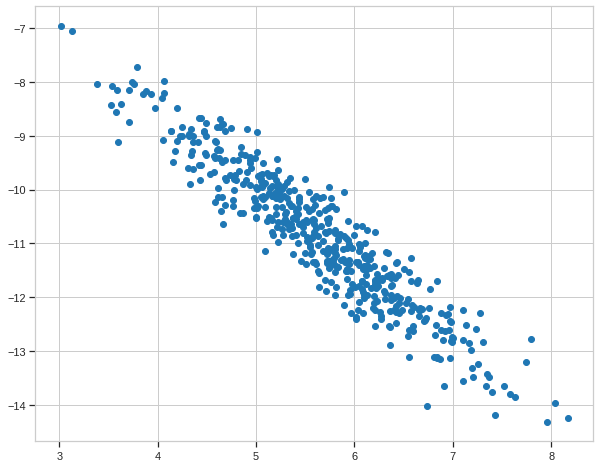

In [25]:
X, _ = make_blobs(n_samples=[500],  random_state=42)
transformation = [[-0.8, 0.9], [0.4, -0.95]]
X = np.dot(X, transformation)
plt.scatter(X[:, 0], X[:, 1]);

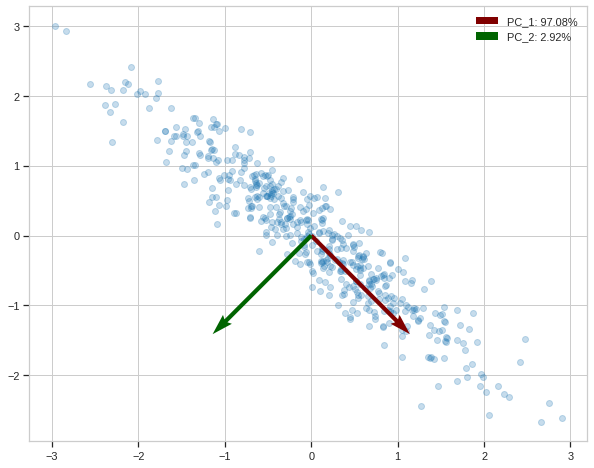

In [26]:

pca = PCA(2)

X = (X - X.mean(axis=0))/X.std(axis=0)
origin =  X.mean(axis=0)
pca.fit(X)
V = pca.components_

plt.scatter(X[:, 0], X[:, 1], alpha = 0.25)
plt.quiver(*origin, V[0, 1], V[0, 0],
           scale = 4,
           color='maroon', label=f'PC_1: {pca.explained_variance_ratio_[0]:.2%}')
plt.quiver(*origin, V[1, 1], V[1, 0],
           scale = 4,
           facecolor='darkgreen', label=f'PC_2: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend()
plt.show()

### Zastosowanie do krzywej OIS

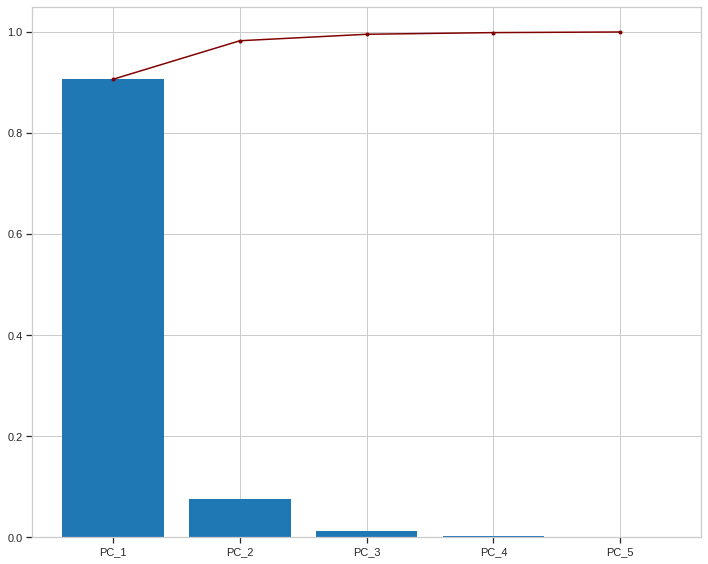

In [27]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
diffs = (rates[ois.columns].sub(rates['SONIA'], axis=0)).diff().dropna()
sc.fit(diffs)

diffs = sc.transform(diffs)
pca = PCA()
pca.fit(diffs)

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
exp_var['Cumulative explained variance'] = pca.explained_variance_ratio_.cumsum()

max_n = 5
plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
plt.tight_layout()

In [28]:
exp_var.head(10)

,Explained variance,Cumulative explained variance
PC_1,0.905902,0.905902
PC_2,0.076155,0.982057
PC_3,0.012818,0.994875
PC_4,0.003290,0.998164
PC_5,0.001214,0.999378
PC_6,0.000392,0.999770
PC_7,0.000158,0.999928
PC_8,0.000050,0.999979
PC_9,0.000016,0.999995
PC_10,0.000004,0.999999


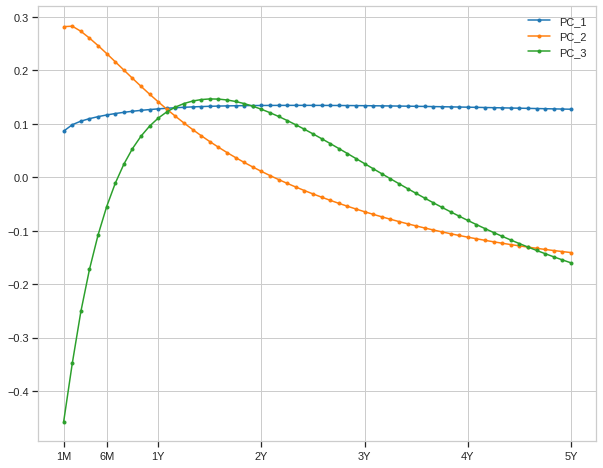

In [29]:
pca = PCA(3)
pca.fit(diffs)

components = pd.DataFrame(pca.components_, 
                          columns = ois.columns,
                          index=[f'PC_{i + 1}' for i in range(pca.n_components)]).T
components.plot(marker='.')
pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
             columns = ['Cumulative explained variance'],
             index = [f'PC_{i+1}' for i in range(pca.n_components)])
tenors = np.array([1, 6, 12, 24, 36, 48, 60]) - 1
plt.xticks(tenors, ois.columns[tenors]);

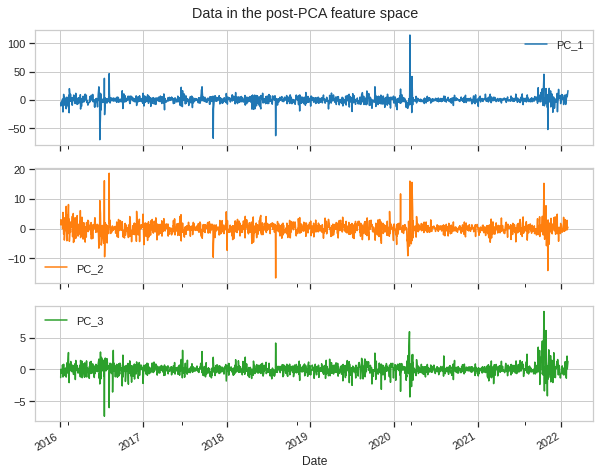

In [30]:
diffs_pca = pd.DataFrame(pca.transform(diffs))
diffs_pca.columns = ['PC_1', 'PC_2', 'PC_3']
diffs_pca.index = rates.diff().dropna().index
diffs_pca.plot(subplots=True)
plt.suptitle('Data in the post-PCA feature space', y =0.92);

## Factor Copula model


### Stacjonarność - ARIMA/GARCH

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


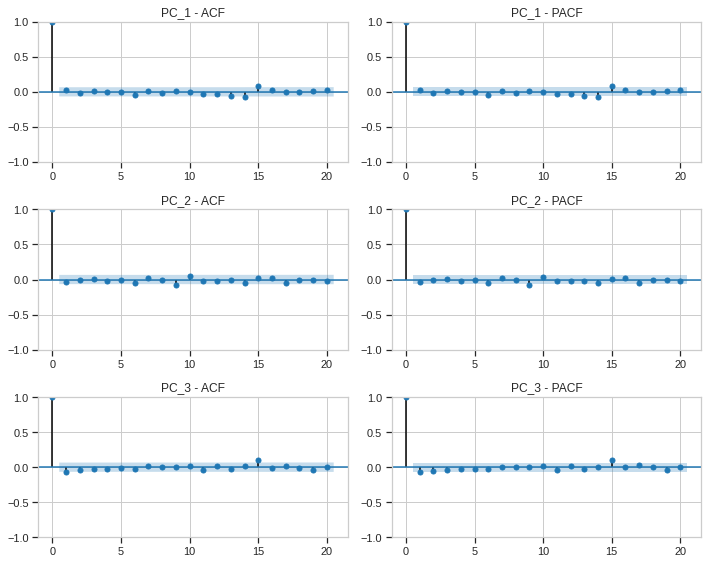

In [38]:
from statsmodels.graphics import tsaplots

fig, ax = plt.subplots(3, 2)

for i, axis in enumerate(ax):
  _ = tsaplots.plot_acf(diffs_pca.iloc[:, i], title=f"PC_{i+1} - ACF", ax = axis[0],
                        zero=True, alpha=0.01, lags=20)
  _ = tsaplots.plot_pacf(diffs_pca.iloc[:, i], title=f"PC_{i+1} - PACF", ax = axis[1], 
                        zero=True, alpha = 0.01, lags=20)

plt.tight_layout()

In [32]:
garch_models={}
garch_residuals ={}
for pc in diffs_pca.columns:
    model = arch_model(diffs_pca.loc[:, pc], mean='Constant', vol='GARCH', p=1, q=1, dist='normal', rescale=True)
    res = model.fit(disp='off')
    garch_models[pc] = res
    garch_residuals[pc] = res.resid/res.conditional_volatility
    
garch_residuals = pd.DataFrame.from_dict(garch_residuals)

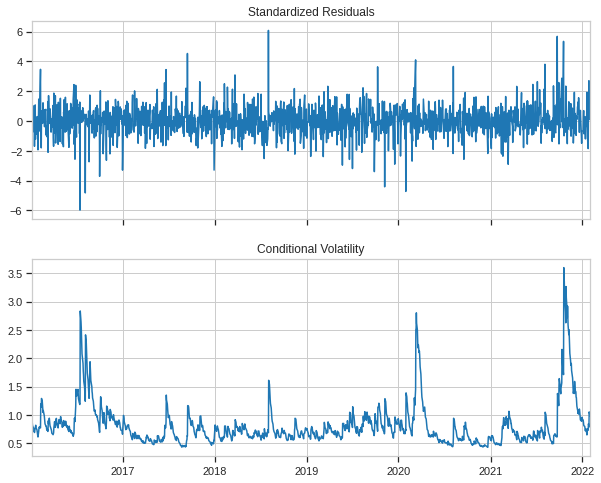

In [40]:
_ = garch_models['PC_3'].plot()

### Kopuły


> Dwuwymiarową kopułą nazywamy funkcję:
> $C: [0, 1]^2 \rightarrow \mathbb{R}, $
> spełniającą warunki:
> * $C(u, 0) = C(0, v) = 0$ (grounded)
> * $C(u, 1) = u \wedge C(1, v)=v$ 
> * $2$-rosnąca

Oznaczmy przez $F_{XY}$ dystrybuantę rozkładu łącznego, $F_X(x)$, $F_Y(y)$ rozkłady brzegowe. Wtedy istnieje dwuwymiarowa kopuła $C$, taka że: 

$$F_{XY}(x, y) = C(F_X(x), F_Y(y)).$$ 

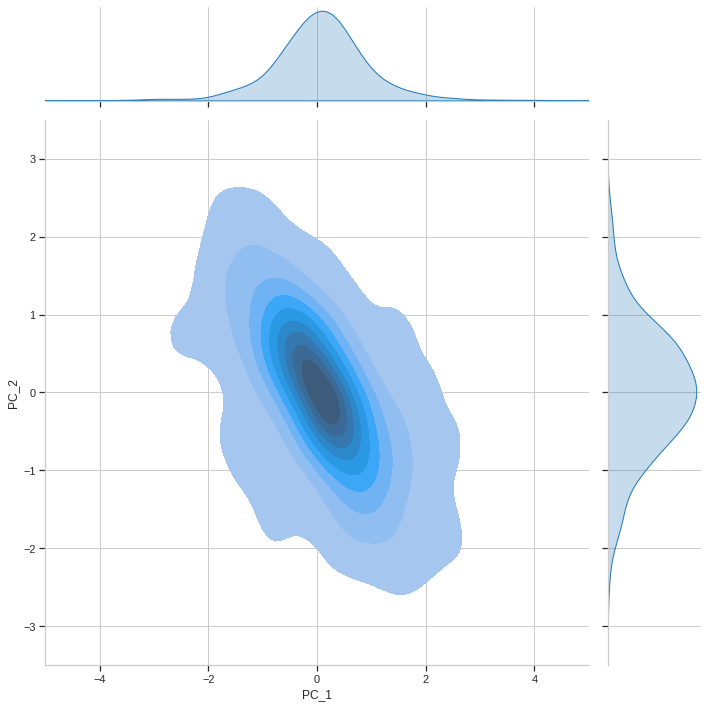

In [42]:
_=sns.jointplot(
    data=garch_residuals,
    x="PC_1", y="PC_2",
    height=10, kind="kde", 
    fill=True, xlim=(-5., 5.), ylim=(-3.5, 3.5))

### Probability Integral Transform

**Idea:** 
* Mając zmienną losową $X$ o ciągłej i odwracalnej dystrybuancie $F(x)$, możemy losować jej realizację losując najperw realizację z rozkładu jednostajnego $u \sim U(0, 1)$ i przyjmując $ x = F^{-1}(u)$. 

To jest metoda odwrotnej dystrybuanty, przydatna w symulacjach. To teraz spójrzmy na to na odwrót:

* Mając pewną zmienną losową $X$ o dystrybuancie $F(x)$ oraz jej realizację $y$, możemy losować realizację z rozkładu jednostajnego przyjmując $u = F(y).$

To jest tzw. *probability integral transform*, i pomoże nam ujednostajnić rozkłady brzegowe wielowymiarowych rozkładów.

> **Tw: (Probability Integral Transform)**
>
>*Założenia:* Zmienna losowa $X$ ma ciągłą dystrybuantę $F_X(x)$.
>
>*Teza:* $F_X(X)\sim U(0, 1)$
>
>*Dowód:*
>
>Zdefiniujmy $Y=F_X(X)$ i zbadajmy rozkład tej zmiennej losowej. Mamy:
>
>$$ P( Y \leq y)  = P\big( F_X(X) \leq y \big) = P\big( X \leq F_X^{-1}(y)\big) = F_X(F^{-1}(y)) = y.$$
>
> Powyższe to dystrybuanta zmiennej losowej jednostajnej, c.n.d.

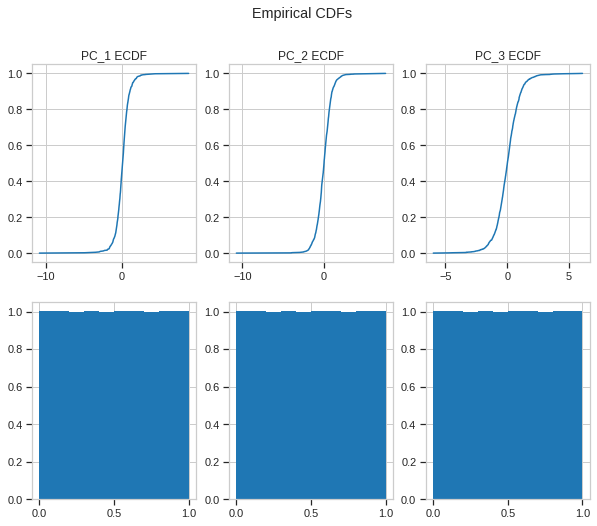

In [60]:
ecdfs = {pc: ECDF(garch_residuals[pc]) for pc in diffs_pca.columns}

fig, ax = plt.subplots(2, 3)

for ind, pc in enumerate(diffs_pca.columns):
    x = garch_residuals[pc].sort_values()
    ax[0][ind].plot(x, ecdfs[pc](x))
    ax[0][ind].set_title(f"{pc} ECDF")
    ax[1][ind].hist(ecdfs[pc](x), density=True, bins=10)

_ = plt.suptitle("Empirical CDFs")

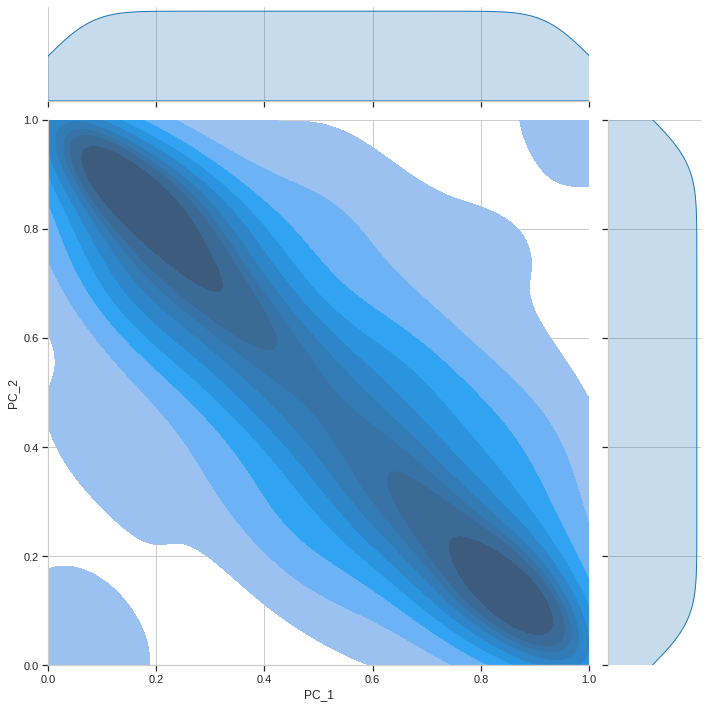

In [61]:
garch_residuals_u_df = garch_residuals.copy()
for ind, pc in enumerate(garch_residuals.columns):
    garch_residuals_u_df[pc] = ecdfs[pc](garch_residuals[pc])

_=sns.jointplot(
    data=garch_residuals_u_df,
    x="PC_1", y="PC_2",
    height=10, kind="kde", 
    fill=True, xlim=(0, 1), ylim=(0, 1))

### Rodzaje kopuł

Mamy całe zoo możliwych kopuł.

* Minimum copula: $C(u_1, u_2) = \min{(u_1, u_2)} $
* Independence copula: $C(u_1, u_2) = u_1u_2$
* Maximum copula: $C(u_1, u_2) = \max{(u_1 + u_2 - 1, 0)} $

> *Tw. Fréchet–Hoeffding*
>
> Dla dowolnej kopuły $C(u_1, u_2)$ mamy ograniczenia dolne i górne:
>
> $$ \max{(u_1 + u_2 - 1, 0)} \leq C(u_1, u_2) \leq \min{(u_1, u_2)}$$ 
>

**Multivariate Copulas**

* Gaussian copula: $C(\mathbf{u}; \Sigma) = \Phi_\Sigma\big(\Phi^{-1}(u_1), \dots, \Phi^{-1}(u_d)\big)$

* Student copula: $C(\mathbf{u}; \Sigma, \nu) = T_{\Sigma, \nu}\big(T_{\nu}^{-1}(u_1), \dots, T_{\nu}^{-1}(u_d)\big) \ $


**Archimedean Copulas**

* Clayton copula: $C(u_1, u_2; \delta) = (u_1^{-\delta} + u_2^{-\delta} - 1)^{-\frac{1}{\delta}}$

* Gumbel copula: $C(u_1, u_2; \delta) = \exp{[-\{(-\ln{u_1})^{\delta} + (-\ln{u_2})^{\delta}\}^{\frac{1}{\delta}}]}$

* Frank copula: $C(u_1, u_2; \delta) = -\frac{1}{\delta}\ln{\bigg(\frac{1}{1-e^{-\delta}}\big[(1-e^{-\delta}) - (1-e^{-\delta u_1})(1-e^{-\delta u_2}) \big]\bigg)} $

* Joe copula: $C(u_1, u_2; \delta) = 1 - \bigg( (1-u_1)^{\delta} + (1-u_2)^{\delta} - (1-u_1)^{\delta}(1-u_2)^{\delta} \bigg)^{\frac{1}{\delta}} $

In [ ]:
def plot_copula_surface(cop, cop_family_name):
    margin = 0.05

    x = np.linspace(margin, 1-margin, 100)
    y = np.linspace(margin, 1-margin, 100)
    X,Y = np.meshgrid(x,y)
    points2D = np.vstack([X.flatten(),Y.flatten()]).T

    Z = cop.pdf(points2D)
    Z = np.reshape(Z, np.shape(X))

    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, 
                                     colorscale='blues_r', showscale=False, 
                                     contours = {"z": {"show": True, 
                                                       "start": Z.min(),
                                                       "end": Z.max(), 
                                                       "size": 0.5, 
                                                       "color": "white"}})])

    camera = dict(
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-0.8, y=-1.35, z=1))

    fig.update_layout(title=f"{cop_family_name} copula", autosize=False,
                      width=500, height=500,
                      margin=dict(l=0, r=0, b=10, t=40), scene_camera=camera)
    return fig